# Import

In [26]:
import bz2
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from torch.utils.data import Dataset, DataLoader
import uuid

import nltk
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import torch
from torch import nn

from torch.utils.data import TensorDataset, DataLoader, random_split
# import torchtext
import collections

import sys
sys.path.append('../')
import contractions
import re

import bz2

# Pretrained bert

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.nn.utils.rnn as rnn_utils

# NLTK package
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

#The essentials
print('stopwords = ', STOPWORDS)

stopwords =  {'both', 'each', 'the', "shan't", 'didn', 'mustn', 'hers', 'were', 'this', 'am', 'yourself', 'below', 'me', 'herself', 'of', 'during', 'where', 'just', 'before', 'he', "shouldn't", 'yours', 'under', 'why', 'did', 'doesn', 'as', 'against', 'into', 'than', "you'll", 're', 's', "couldn't", 'its', 'in', 'such', 'doing', 'should', "you've", "didn't", 'what', 'between', 'it', 'them', 'because', 'm', 'there', 'down', 'only', "should've", 'mightn', 'being', 'and', 'most', 'needn', 'nor', 'all', 'at', 'who', 'wasn', 'myself', "that'll", 'same', 'our', 'you', 'll', 'been', 'ma', 'she', 'up', 'very', 'not', 'here', 'ain', 'but', "mustn't", 've', 'on', 'out', 'that', 'his', 'those', 'after', 'has', 'once', 'yourselves', 'was', 'd', 'my', 'itself', "don't", 'again', 'himself', 'is', "needn't", 'him', 'haven', 'until', 'no', 'or', "doesn't", 'o', 't', "aren't", 'so', 'by', 'weren', "hasn't", 'i', 'will', "she's", 'have', "isn't", 'through', 'a', 'how', "won't", 'then', "it's", 'their', 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# root = os.getcwd()
# datasetpath = os.path.join(root, 'dataset')
# assert os.path.exists(datasetpath), f'dataset path does not exist {datasetpath}'

# Constants 

In [27]:
ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'amazon_review', 'train.ft.txt.bz2')
sample_train_df_path = os.path.join(ROOT,'dataset', 'amazon_review', 'sample_train.csv')
sample_test_df_path = os.path.join(ROOT,'dataset', 'amazon_review', 'sample_val.csv')

OUTPUT_PATH = os.path.join(ROOT, 'output', 'bert')

if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)

BATCH_SIZE = 32

# Load the whole dataset and truncate it (for experiments)

In [78]:
# train_txt = bz2.BZ2File(os.path.join(datasetpath, 'train.ft.txt.bz2'))
# train_txt = bz2.BZ2File('/content/drive/MyDrive/UB/Sem 2/DL/DL FINAL Project/train.ft.txt.bz2')

train_txt = bz2.BZ2File(DATASET_PATH)
train_lines = train_txt.readlines()

In [79]:
for line in train_lines[:5]:
    print(line)

b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'
b"__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n"
b'__label__2 Amazing!: This sou

In [80]:
#only tkae 10% of this dataset
LIMIT = int(0.01 * len(train_lines))
print('limit = ', LIMIT)

truncated_train_lines = train_lines[:LIMIT]

TRAIN_RATIO = 0.9
train_len = int(len(truncated_train_lines) * TRAIN_RATIO)

train_array = [x.decode('utf-8') for x in truncated_train_lines[:train_len]]
test_array = [x.decode('utf-8') for x in truncated_train_lines[train_len:]]

#apply limit to a big dataset
train_array = train_array[:LIMIT]

print('train len = ', len(train_array))
print('test len = ', len(test_array))

limit =  36000
train len =  32400
test len =  3600


In [82]:
# Saving the truncated dataset
sample_train_dataset = os.path.join(ROOT,'dataset','amazon_review', 'sample_train_array.pkl')
sample_test_dataset = os.path.join(ROOT,'dataset','amazon_review', 'test_train_array.pkl')

print(type(train_array))
print('len of train array = ', len(train_array))
print(type(test_array))
print('len of val array = ', len(test_array))

<class 'list'>
len of train array =  32400
<class 'list'>
len of val array =  3600


In [85]:
def convert_to_df(array):
    X_array = []
    y_array = []

    for line in array:
        parts = line.split(' ')
        label = parts[0]
        feature = ' '.join(parts[1:])

        X_array.append(feature)
        y_array.append(label)

    df = pd.DataFrame({'label':y_array, 'text':X_array})
    return df

train_df = convert_to_df(train_array)
test_df = convert_to_df(test_array)

print('train df = ', train_df.shape)
print('test df = ', test_df.shape)

train_df.to_csv(sample_train_df_path, index=False)
test_df.to_csv(sample_test_df_path, index=False)

train df =  (32400, 2)
test df =  (3600, 2)


# Loading the sample_dataset

In [13]:
train_df = pd.read_csv(sample_train_df_path)
test_df = pd.read_csv(sample_test_df_path)

# Process the dataset

- for experiments, work on the truncated_train.ft.txt.bz2 file
- Clean the text here

In [14]:
train_df['length'] = train_df['text'].apply(lambda s: len(s))
test_df['length'] = test_df['text'].apply(lambda s: len(s))

print(train_df.shape)
train_df.head()

(32400, 3)


,label,text,length
0,__label__2,Stuning even for the non-gamer: This sound tra...,427
1,__label__2,The best soundtrack ever to anything.: I'm rea...,510
2,__label__2,Amazing!: This soundtrack is my favorite music...,761
3,__label__2,Excellent Soundtrack: I truly like this soundt...,744
4,__label__2,"Remember, Pull Your Jaw Off The Floor After He...",482


In [15]:
print(test_df.shape)
test_df.head()

(3600, 3)


,label,text,length
0,__label__1,Bottom of the Barrel Actioner: Summary: Two L....,396
1,__label__1,For what it's worth....: If you're out to coll...,658
2,__label__1,"Not real happy: Product come on time, and was ...",771
3,__label__1,Sure To Break Your Heart: This is a warning to...,386
4,__label__1,Outdated and non-essential: Get the following ...,298


# A little EDA

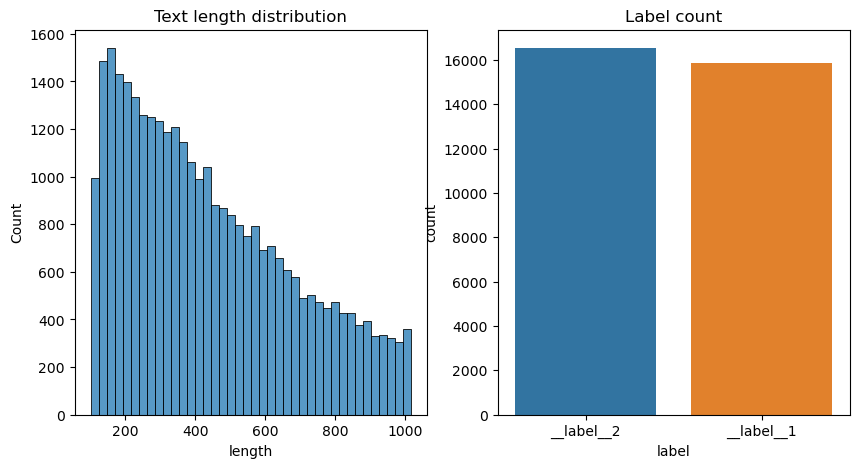

In [8]:
#plot 2, hist of length
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.histplot(train_df, x = 'length', ax = ax1)
ax1.set_title("Text length distribution")
sns.countplot(train_df, x = 'label', ax = ax2)
ax2.set_title("Label count")
plt.show()

# Build array

In [16]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #__label__1 = 0: bad review, __label__2 = 1,good review
    text = ' '.join(t for t in text.split() if t != '')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)

'test string special characters punctuations _'

In [17]:
train_df['target'] = train_df['label'].apply(lambda x: 1 if x == '__label__2' else 0)
train_df['clean_text'] = train_df['text'].apply(lambda x: clean_text(x))
train_df['target'].value_counts()

test_df['target'] = test_df['label'].apply(lambda x: 1 if x == '__label__2' else 0)
test_df['clean_text'] = test_df['text'].apply(lambda x: clean_text(x))
test_df['target'].value_counts()



target
0    1961
1    1639
Name: count, dtype: int64

In [18]:
train_df.head(5)

,label,text,length,target,clean_text
0,__label__2,Stuning even for the non-gamer: This sound tra...,427,1,stuning even non gamer sound track beautiful p...
1,__label__2,The best soundtrack ever to anything.: I'm rea...,510,1,best soundtrack ever anything reading lot revi...
2,__label__2,Amazing!: This soundtrack is my favorite music...,761,1,amazing soundtrack favorite music time hands i...
3,__label__2,Excellent Soundtrack: I truly like this soundt...,744,1,excellent soundtrack truly like soundtrack enj...
4,__label__2,"Remember, Pull Your Jaw Off The Floor After He...",482,1,remember pull jaw floor hearing played game kn...


**BERT**

In [69]:
# tr_df, val_df = train_test_split(train_df, test_size=0.2)
# tr_df, val_df = train_test_split(tr_df, test_size=0.2)

In [19]:
class AmazonReviewDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        review = self.df['clean_text'].iloc[idx]
        label = self.df['target'].iloc[idx]
#         print('idx', idx)

        # Tokenize the review
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    input_ids = rnn_utils.pad_sequence(input_ids, batch_first=True)
    attention_mask = rnn_utils.pad_sequence(attention_mask, batch_first=True)
    labels = torch.tensor(labels)
#     print(len(input_ids), len(attention_mask), len(labels))

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# BERT pretrained

In [20]:
model_name = 'prajjwal1/bert-mini'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
indices = [3332, 8107, 69566, 25697, 86807, 26598, 37591, 29156]

# Iterate over each index and print the required information
for idx in indices:
    if idx in train_df.index:  # Check if the index exists in the DataFrame
        text = train_df['text'][idx]
        target = train_df['target'][idx]
        text_length = len(text)
        print(f"Index {idx}:")
        print(f"Text: {text}")
        print(f"Length of Text: {text_length}")
        print(f"Target: {target}\n")
    else:
        print(f"Index {idx} not in DataFrame.\n")


Index 3332:
Text: hi-tec mens altitude IV: great boots even works great while walking up wet boards!!! buy this product you will not be sorry, well made and true to size.

Length of Text: 153
Target: 1

Index 8107:
Text: ORIGINAL MUCH BETTER: THE ORIGINIAL OF THIS MOVIE WAS MUCH BETTER. THE SPECIAL EFFECTS IN THIS REMAKE ARE BETTER-BUT THE PLOT IS NOTHING LIKE THE ORIGINAL.

Length of Text: 156
Target: 0

Index 69566 not in DataFrame.

Index 25697:
Text: TRUTH: this film was funded by the centeral intelligence agency in the 1950s and was maipulated to suit the need of a capitalistic propoganda machine

Length of Text: 150
Target: 0

Index 86807 not in DataFrame.

Index 26598:
Text: 1 star for the edition, 3 for the movie: Not a very great sequel (like most), but come on, enough already with the double dipping. Granted, we all KNEW this would come out as soon as they announced the third film (I don't count any film starring a has been wrestler as a sequel, sorry, that's just how I roll)

# Create dataset and dataloader

In [21]:
total_train_len = len(train_df)
train_len = int(0.8 * total_train_len) 
val_len = int(0.2 * total_train_len) 

train_dataset = AmazonReviewDataset(train_df, tokenizer)

train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])
test_dataset = AmazonReviewDataset(test_df, tokenizer)

In [23]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print('train dataloader = ', len(train_dataloader))
print('valid dataloader = ', len(val_dataloader))
print('test dataloader = ', len(test_dataloader))

train dataloader =  810
valid dataloader =  203
test dataloader =  113


# Training utils

In [28]:
def get_accuracy(predictions, labels):
    return (predictions == labels).sum() / len(labels)

def train(dataloader, model, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm(dataloader, desc="training..."):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        output = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = output.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        logits = output.logits
        predictions = torch.argmax(logits, dim=1)
        accuracy = get_accuracy(predictions, labels)

        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm(dataloader, desc="evaluating..."):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        output = model(input_ids, attention_mask=attention_mask, labels=labels)

        logits = output.logits
        predictions = torch.argmax(logits, dim=1)
        accuracy = get_accuracy(predictions, labels)

        epoch_losses.append(output.loss.item())
        epoch_accs.append(accuracy.item())

            
    return np.mean(epoch_losses), np.mean(epoch_accs)

def plot(history, save_fig = None, show = False):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))

    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    sns.lineplot(y = history["test_accs"],  label ='test accuracy', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["test_losses"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

    if save_fig:
        plt.savefig(save_fig)
    if show:
        plt.show()

def tune(model, optimizer, device, train_dataloader, val_dataloader, test_dataloader, epochs = 10):
    label = str(uuid.uuid4()).split('-')[0]
    print('run id = ', label)
    SAVE_PATH = os.path.join(OUTPUT_PATH, label)
    PLOT_PATH = os.path.join(SAVE_PATH, 'plot.png')

    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    best_valid_loss = float("inf")
    history = collections.defaultdict(list)

    model.to(device)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, device)
        test_loss, test_acc = evaluate(test_dataloader, model, device)

        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        history["test_losses"].append(test_loss)
        history["test_accs"].append(test_acc)

        if val_loss < best_valid_loss:
            best_valid_loss = val_loss 
            torch.save(model, os.path.join(SAVE_PATH, 'bert.checkpoint.torch'))

        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

        plot(history, save_fig=PLOT_PATH)
    
    plot(history, show=True)
    



# Tune

CUDA Device Name: NVIDIA GeForce RTX 3060
run id =  6f6eca0c


evaluating...: 100%|██████████| 113/113 [00:09<00:00, 12.20it/s]


epoch: 0
train_loss: 0.413, train_acc: 0.807
val_loss: 0.326, valid_acc: 0.861
test_loss: 0.301, test_acc: 0.878


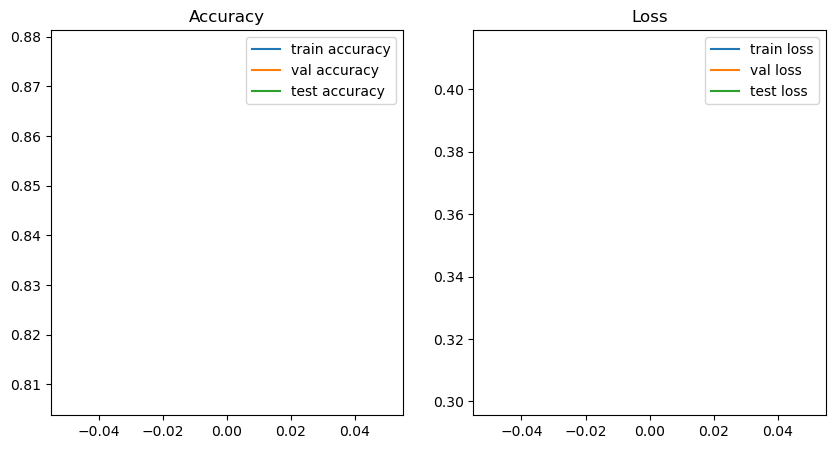

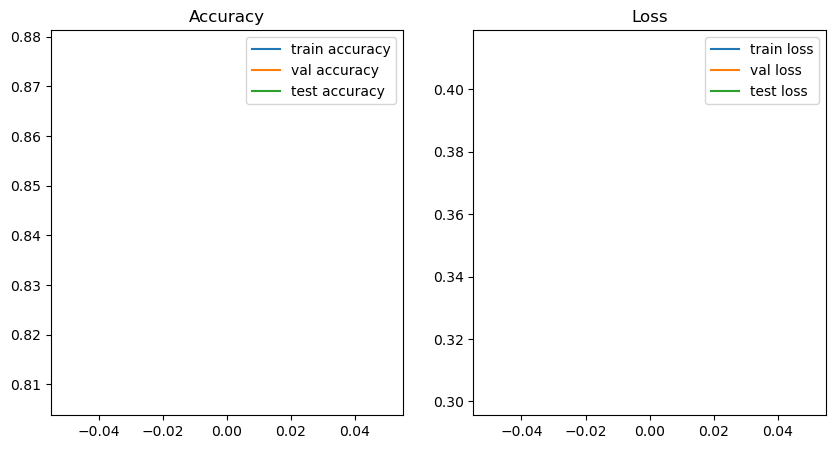

In [30]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_name = torch.cuda.get_device_name(torch.cuda.current_device())
print("CUDA Device Name:", device_name)
training_epochs = 10

tune(model, optimizer, device, train_dataloader, val_dataloader, test_dataloader,
      epochs = 1)